To make a meaningful comparison I think I need to know more about my source behaviour. However I can still get a point spread function

In [124]:
from ParticleTracerClass import ParticleTracer
from phaseSpaceAnalyzer import SwarmSnapShot
import dill
from tqdm import tqdm
import time
from SwarmTracerClass import SwarmTracer
import warnings
import numpy as np
from ParticleClass import Swarm
from ParticleClass import Particle as ParticleBase
from ParticleTracerLatticeClass import ParticleTracerLattice
import matplotlib.pyplot as plt
import pathos as pa


LObject=70.0E-2
LImage=85E-2
LLensHardEdge=15.24e-2
rpLens=(5e-2,7.54e-2)
magnetWidth=(.0254,.0254*1.5)

fringeFrac=1.5
LFringe=fringeFrac*max(rpLens)
LLens=LLensHardEdge+2*LFringe
LObject-=LFringe
LImage-=LFringe

PTL=ParticleTracerLattice(v0Nominal=210.0,latticeType='injector')
PTL.add_Drift(LObject,ap=.07)
PTL.add_Halbach_Lens_Sim(rpLens,LLens,magnetWidth=magnetWidth,apFrac=.8)
PTL.add_Drift(LImage*2,ap=.07)
assert PTL.elList[1].fringeFracOuter==fringeFrac and abs(PTL.elList[1].Lm-LLensHardEdge)<1e-9
PTL.end_Lattice()

# file=open('collectorLensLattice','wb')
# dill.dump(PTL,file)
# file=open('collectorLensLattice','rb')
# PTL=dill.load(file)
# file.close()

# Interpolation function

In [125]:

class Interpolater:
    def __init__(self,swarm,PTL):
        self.swarm=swarm
        self.PTL=PTL
        self.endDriftLength=abs(self.PTL.elList[-1].r2[0]-self.PTL.elList[-1].r1[0])
    def __call__(self,xOrbit,maxRadius=np.inf,vTMax=np.inf,returnP=False,useAssert=True,useInitial=False):
        #xOrbit: Distance in orbit frame, POSITIVE to ease with analyze. Know that the tracing is done with x being negative
        #returns in units of mm
        #vTMax: maximum transverse velocity for interpolation
        #useAssert: I can use this interplater elsewhere if I turn this off
        if useAssert==True:
            assert -self.PTL.elList[-1].r2[0]>xOrbit>-self.PTL.elList[-1].r1[0]
        yList=[]
        zList=[]
        pList=[]
        for particle in self.swarm.particles:
            if useInitial==True:
                p,q=particle.pi,particle.qi
            else:
                p,q=particle.pf,particle.qf
            vT=np.sqrt(p[1]**2+p[2]**2)
            if (q[0]<-xOrbit and vT<vTMax) or useInitial==True:
                stepFrac=(abs(q[0])-xOrbit)/self.endDriftLength
                ySlope=p[1]/p[0]
                y=q[1]+stepFrac*self.endDriftLength*ySlope
                zSlope=p[2]/p[0]
                z=q[2]+stepFrac*self.endDriftLength*zSlope
                yList.append(y)
                zList.append(z)
                pList.append(p)
        yArr=np.asarray(yList)*1e3
        zArr=np.asarray(zList)*1e3
        rArr=np.sqrt(yArr**2+zArr**2)
        yArr=yArr[rArr<maxRadius]
        zArr=zArr[rArr<maxRadius]
        pArr=np.asarray(pList)[rArr<maxRadius]
        returnArgs=[yArr,zArr]
        if returnP==True:
            returnArgs.append(pArr)
        return returnArgs


# Analyze point spread function

In [126]:
#generate traced swarm and interpolate
import multiprocess
from ParticleTracerClass import ParticleTracer
import random
import pickle

swarmTracer=SwarmTracer(PTL)
particleTracer=ParticleTracer(PTL)
numParticles=100_000
fastMode=True
h=5e-6
v0=210.0
sourceAngle=.08
swarmInitial=swarmTracer.initalize_PseudoRandom_Swarm_In_Phase_Space(1e-9,sourceAngle*v0,1e-9,numParticles,circular=True)

yShift=0.0
for particle in swarmInitial:
  particle.qi[1]+=yShift



t=time.time()
swarmTraced=swarmTracer.trace_Swarm_Through_Lattice(swarmInitial,h,1.0,fastMode=fastMode,copySwarm=False,parallel='superfast')
print(time.time()-t) #23
interpFunction=Interpolater(swarmTraced,PTL)

# PTL.show_Lattice(swarm=swarmTraced,showTraceLines=True,trueAspectRatio=False)

112.47709107398987


1.73981398139814 3.8477636505628086


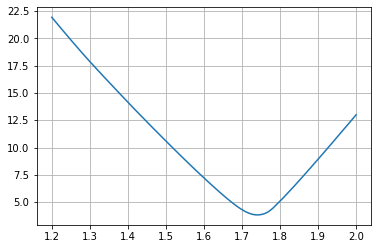

In [127]:
#don't attempt this on huge numbers of particles. Use a smaller number here like 100,000
from joblib import Parallel,delayed
import multiprocess
import scipy.interpolate as spi

#find circle of least confusion location
swarmTestMin=Swarm()
swarmTestMin.particles=swarmTraced.particles[:100_000]
interpFunctionMin=Interpolater(swarmTestMin,PTL)
xArr=np.linspace(1.2,2.,100)
frac=.9 #fraction to define circle

def circleRadius(x):
  xCoords,yCoords=interpFunctionMin(x)
  r=np.sqrt(xCoords**2+yCoords**2)
#   return np.std(r)
  r=np.sort(r)
  assert len(r)>10 
#   print(int(frac*len(r)))
  rCutoff=r[int(frac*len(r))]
  return rCutoff


with multiprocess.Pool(10) as pool:
    circleRadiusArr=np.asarray(pool.map(circleRadius,xArr))
interpFunc=spi.RBFInterpolator(xArr[:,np.newaxis],circleRadiusArr)
  

xArrDense=np.linspace(xArr[0],xArr[-1],10000)
yArrDense=interpFunc(xArrDense[:,np.newaxis])

xMin=xArrDense[np.argmin(yArrDense)]

print(xMin,np.min(yArrDense)) #1.7402940294029403 3.8333550288953804

plt.plot(xArr,circleRadiusArr)
# plt.plot(xArrDense,yArrDense,c='r')
plt.grid()
plt.show()



1255 1.0


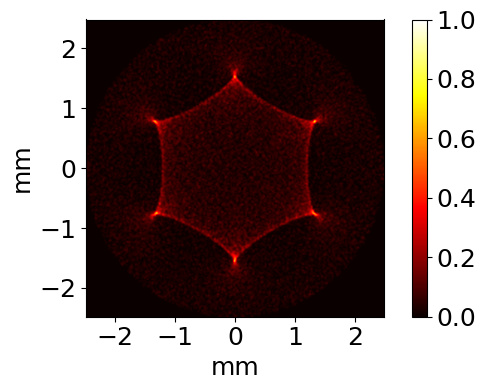

In [128]:
# %matplotlib tk
import celluloid
yArr,zArr=interpFunction(xMin)
rArr=np.sqrt(yArr**2+zArr**2)
rMax=2.5 #mm
yArr=yArr[rArr<rMax]
zArr=zArr[rArr<rMax]
image,yBins,zBins=np.histogram2d(yArr,zArr,bins=200)
image=image/image.max()
print(int(image.sum()),image.max())
yMin=yBins[0]+(yBins[1]-yBins[0])/2
yMax=yBins[-1]-(yBins[1]-yBins[0])/2
zMin=zBins[0]+(zBins[1]-zBins[0])/2
zMax=zBins[-1]-(zBins[1]-zBins[0])/2
plt.figure(dpi=100)
plt.imshow(image,extent=[zMin,zMax,yMin,yMax],cmap='hot',interpolation='bicubic')#,vmin=0.0,vmax=25.6/10.0)
plt.xlabel('mm',fontsize=18)
plt.ylabel('mm',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
bar=plt.colorbar()
bar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('focusImage')
plt.show()



1.394628409457892


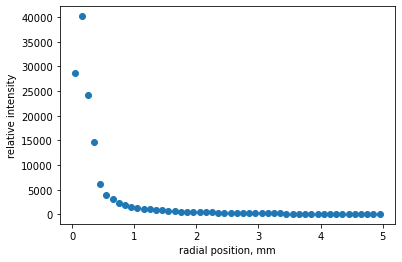

In [129]:
yArr,zArr=interpFunction(1.82,maxRadius=5)
rArr=np.sqrt(yArr**2+zArr**2)
print(np.std(rArr))

vals,bins=np.histogram(rArr,bins=50)
# The vals here are basically integreated flux
import scipy.signal as sps
binSize=bins[1]-bins[0]
rBinArr=bins[:-1]+binSize/2
radiusWeight=1/(rBinArr*binSize*2*np.pi)


vals=vals*radiusWeight
smoothStartDistance=-1
# vals[:smoothStartDistance]=sps.savgol_filter(vals[:smoothStartDistance],11,2)
# vals=vals/vals.max()

# rLeastConfuse=circleRadius(xMin)

# plt.figure(dpi=150)
plt.scatter(rBinArr,vals)
# plt.hist(rArr,bins=300)
plt.xlabel('radial position, mm')
plt.ylabel('relative intensity')

# plt.axvline(x=rLeastConfuse,c='black',linestyle=':')
plt.savefig("focusIntensity")
plt.show()

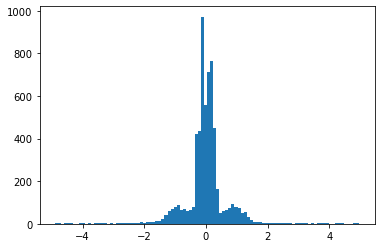

In [130]:
plt.hist(zArr[np.abs(yArr)<.1],bins=100)
plt.show()

## analyze flourescence signal
This if kind of crappy. Not worked out yet